Causal Impact
=============

A Python package for causal inference using Bayesian structural time-series models. It's a port of the R package CausalImpact, see https://github.com/google/CausalImpact.
  
### What does the package do?
This package implements an approach to estimating the causal effect of a designed intervention on a time series. For example, how many additional daily clicks were generated by an advertising campaign? Answering a question like this can be difficult when a randomized experiment is not available.

### How does it work?
Given a response time series (e.g., clicks) and a set of control time series (e.g., clicks in non-affected markets or clicks on other sites), the package constructs a Bayesian structural time-series model. This model is then used to try and predict the counterfactual, i.e., how the response metric would have evolved after the intervention if the intervention had never occurred. For details, see: [Brodersen et al., Annals of Applied Statistics (2015)](http://research.google.com/pubs/pub41854.html).

### What assumptions does the model make?
As with all non-experimental approaches to causal inference, valid conclusions require strong assumptions. In the case of CausalImpact, we assume that there is a set control time series that were *themselves not affected by the intervention.* If they were, we might falsely under- or overestimate the true effect. Or we might falsely conclude that there was an effect even though in reality there wasn't. The model also assumes that the relationship between covariates and treated time series, as established during the pre-period, remains stable throughout the post-period (see `impact.model_args["dynamic_regression"]` for a way of relaxing this assumption). Finally, it's important to be aware of the *priors* that are part of the model (see `impact.model_args["prior_level_sd"]` in particular).

### How is the package structured?
The package is designed to make counterfactual inference as easy as fitting a regression model, but much more powerful, provided the assumptions above are met. The package has a single entry point, the function `CausalImpact()`. Given a response time series and a set of control time series, the function constructs a time-series model, performs posterior inference on the counterfactual, and returns a `CausalImpact` object. The results can be summarized in terms of a table, a verbal description, or a plot.


### 1. Installing the package

To install `causalimpact` run:

In [1]:
# !pip install causalimpact

Once installed, the package can be imported using:

In [2]:
from causalimpact import CausalImpact

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 2. Creating an example dataset

To illustrate how the package works, we create a simple toy dataset. It consists of a response variable `y` and a predictor `x1`. Note that in practice, we'd strive for including many more predictor variables and let the model choose an appropriate subset. The example data has 100 observations. We create an *intervention effect* by lifting the response variable by 10 units after timepoint 71.


In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 6)

np.random.seed(1)

x1 = arma_generate_sample(ar=[0.999], ma=[0.9], nsample=100) + 100
y = 1.2 * x1 + np.random.randn(100)

y[71:100] = y[71:100] + 10
data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])

We now have a simple matrix with 100 rows and two columns:

In [4]:
data.shape
data.head()

,y,x1
0,121.308920,101.463374
1,120.563149,99.448868
2,119.832495,99.524170
3,119.433612,99.033362
4,119.840664,100.779647


We can visualize the generated data using:

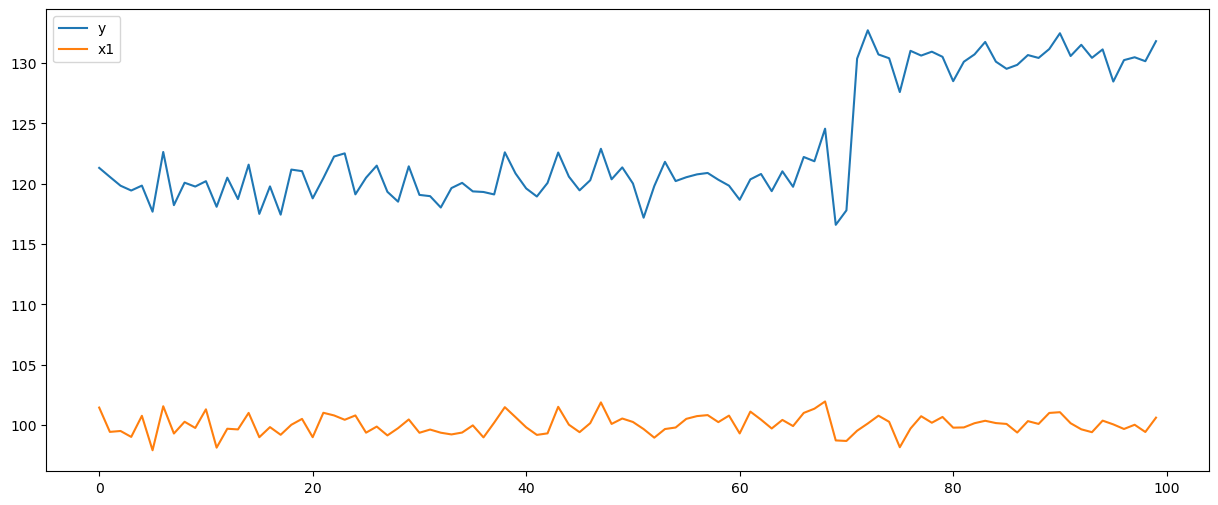

In [5]:
data.plot();

## 3. Running an Analysis

To estimate the causal effect, we begin by specifying which period in the data should be used for training the model (pre-intervention period) and which period for computing a counterfactual prediction (post-intervention period).

In [6]:
pre_period = [0,69]
post_period = [71,99]

This says that time points 0...70 will be used for training, and time points 71...99 will be used for computing predictions. Alternatively, we could specify the periods in terms of dates or time points; see <a href="#5.-Working-with-dates-and-times">Section 5</a> for an example.

To perform inference, we run the analysis using:

In [7]:
impact = CausalImpact(data, pre_period, post_period)

This initialises a `CausalImpact` object

In [8]:
impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06685D+00    |proj g|=  4.25552D-01

At iterate    5    f=  9.89784D-01    |proj g|=  2.23487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.157D-05   9.898D-01
  F =  0.98978278136724052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


This instructs the package to assemble a structural time-series model, fit the model using MLE by default, and compute estimates 
of the causal effect. We can view the results in a dataframe as follows:

## 4. Plotting the results
The easiest way of visualising the results is to use the `plot()` method of the `CausalImpact` object

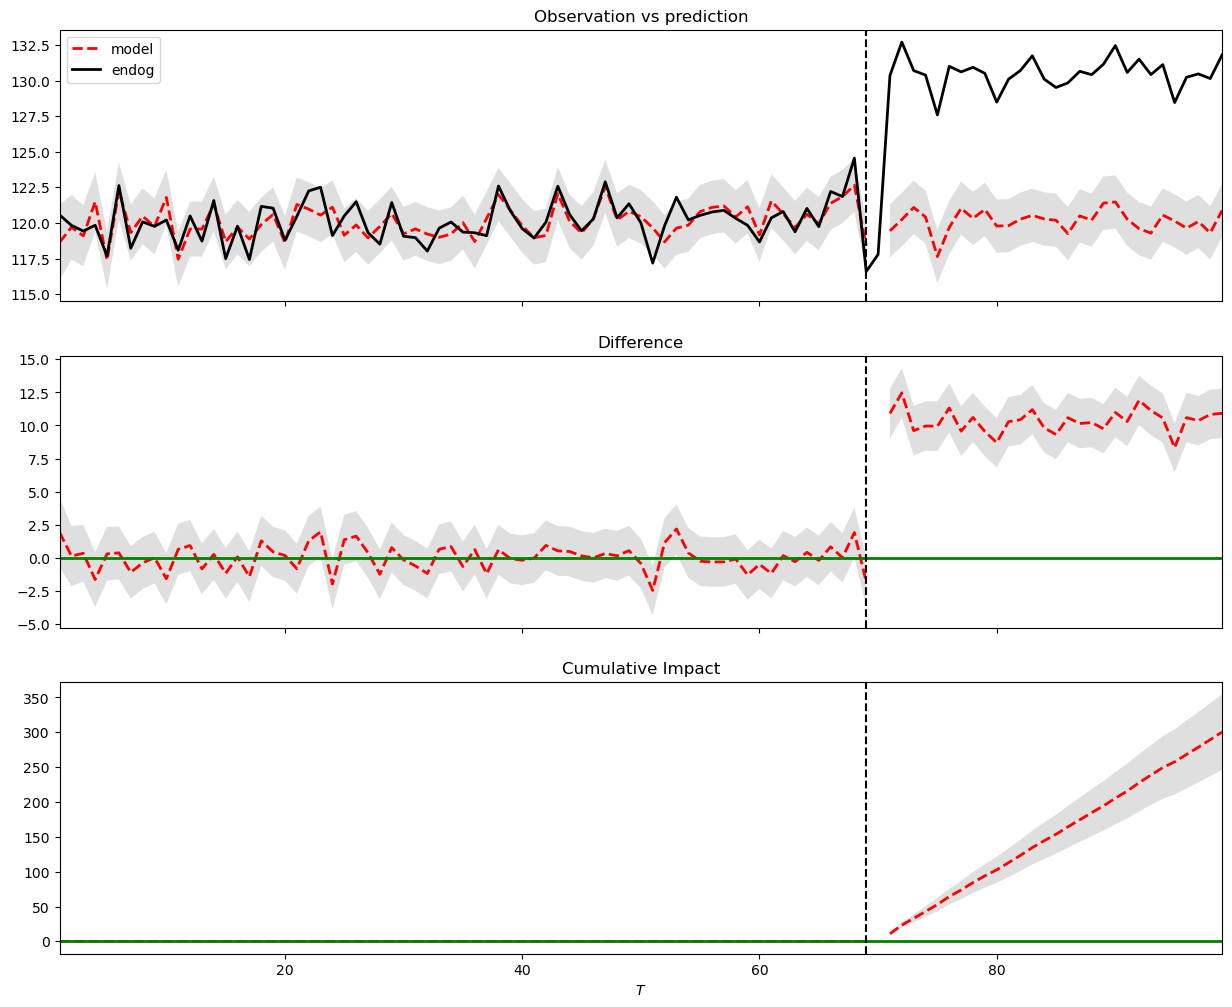

In [9]:
impact.plot()

By default, the plot contains three panels. The first panel shows the data and a counterfactual prediction for the post-treatment period. The second panel shows the difference between observed data and counterfactual predictions. This is the *pointwise* causal effect, as estimated by the model. The third panel adds up the pointwise contributions from the second panel, resulting in a plot of the *cumulative* effect of the intervention.

Remember, once again, that all of the above inferences depend critically on the assumption that the covariates were not themselves affected by the intervention. The model also assumes that the relationship between covariates and treated time series, as established during the pre-period, remains stable throughout the post-period.


## 5. Working with dates and times

It is often more natural to feed a time-series object into `CausalImpact()` rather than a data frame. For example, we might create a `data` variable as follows:


In [10]:
date_range = pd.date_range(start="2014-01-01", periods=100)
ts_data = data.copy()
ts_data.index = date_range
ts_data.head()

,y,x1
2014-01-01,121.308920,101.463374
2014-01-02,120.563149,99.448868
2014-01-03,119.832495,99.524170
2014-01-04,119.433612,99.033362
2014-01-05,119.840664,100.779647


We can now specify the pre_period and post_period in terms of time points rather than indices:

In [11]:
ts_pre_period = [pd.to_datetime(date) for date in ["2014-01-01", "2014-03-12"]]
ts_post_period = [pd.to_datetime(date) for date in ["2014-03-13", "2014-04-10"]]

As a result, the x-axis of the plot shows time points instead of indices:

In [12]:
ts_impact = CausalImpact(ts_data, ts_pre_period, ts_post_period)
ts_impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03579D+00    |proj g|=  4.35257D-01

At iterate    5    f=  9.74586D-01    |proj g|=  1.50180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     10      1     0     0   1.502D-04   9.746D-01
  F =  0.97458627690388255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [13]:
ts_impact.inferences.head(2)

,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
2014-01-01,121.308920,121.30892,121.994854,-2804.815502,3048.805211,121.994854,-2804.815502,3048.805211,-0.685934,2926.124423,-2927.496290,0.0,0.0,0.0
2014-01-02,120.563149,241.87207,118.618185,116.007655,121.228715,240.613039,-2688.807847,3170.033926,1.944964,4.555494,-0.665566,0.0,0.0,0.0


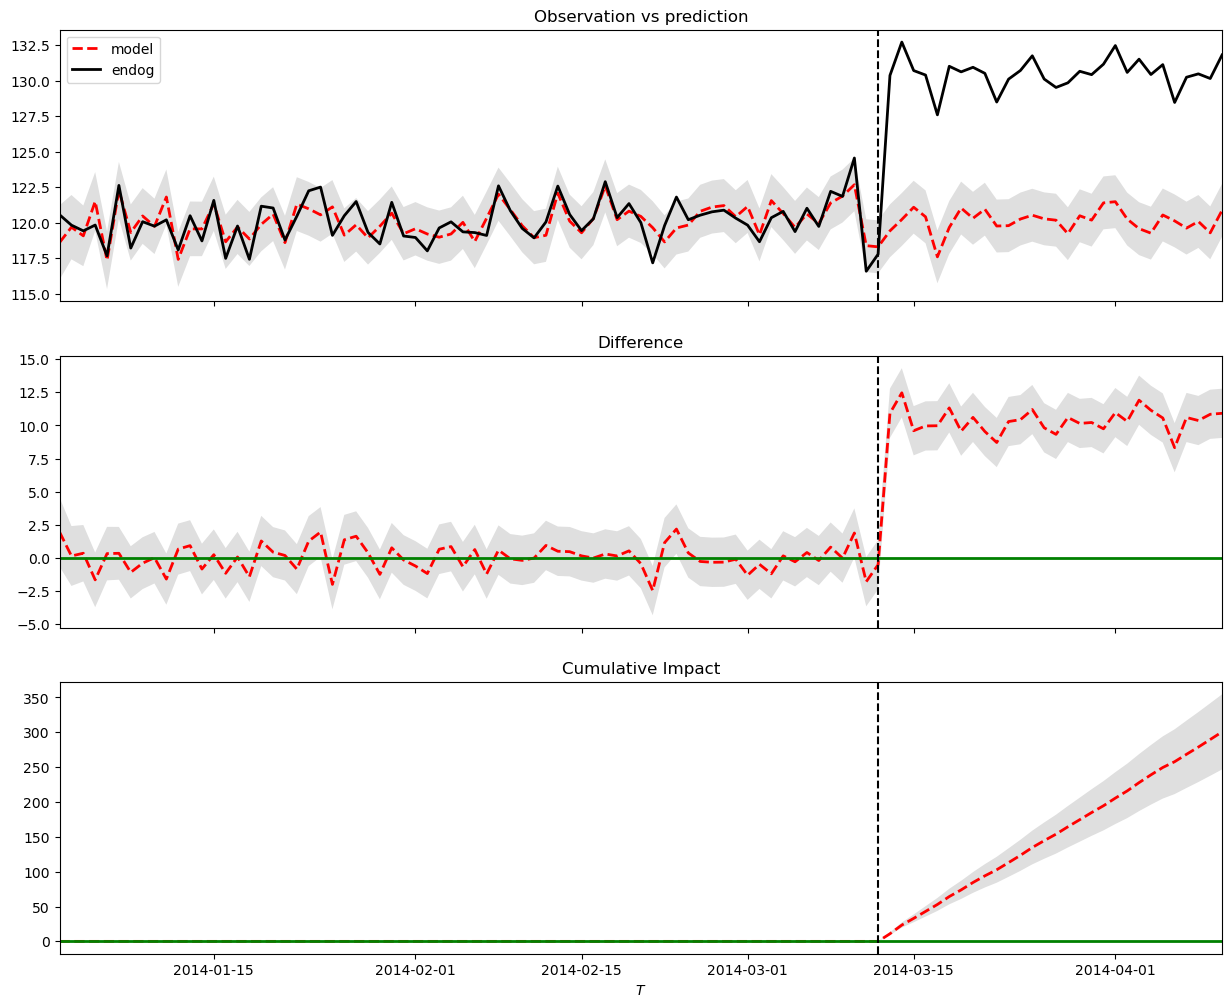

In [14]:
ts_impact.plot()

## 6. Printing a summary table

To obtain a numerical summary of the analysis we use: 

In [15]:
ts_impact.summary()

                              Average     Cumulative
Actual                            130           3784
Predicted                         120           3484
95% CI                     [118, 122]   [3430, 3538]
                                                    
Absolute Effect                    10            300
95% CI                        [12, 8]     [354, 246]
                                                    
Relative Effect                  8.6%           8.6%
95% CI                  [10.2%, 7.1%]  [10.2%, 7.1%]
                                                    
P-value                          0.0%               
Prob. of Causal Effect         100.0%               


The **Average** column talks about the average (across time) during the post-intervention period (in the example: time points 71 through 100). The **Cumulative** column sums up individual time points, which is a useful perspective if the response variable represents a flow quantity (such as queries, clicks, visits, installs, sales, or revenue) rather than a stock quantity (such as number of users or stock price).

In the example, the estimated average causal effect of treatment was 11 (rounded to a whole number; for full precision see `impact$summary`). This is because we observed an average value of 99 but would have expected an average value of only 89. The 95% posterior interval of the average effect is [9.8, 11]. Since this excludes 0, we (correctly) conclude that the intervention had a causal effect on the response variable. Since we generated the data ourselves, we know that we injected a true effect of 10, and so the model accurately recovered ground truth. One reason for this is that we ensured, by design, that the covariate `x1` was not itself affected by the intervention. In practice, we must always reason whether this assumption is justified.

For additional guidance about the correct interpretation of the summary table, the package provides a verbal interpretation, which we can print using:


In [16]:
ts_impact.summary(output="report")

During the post-intervention period, the response             variable had an average value of             approx. 130.
By contrast, in  the absence of an intervention, we would have expected an average response of 120. The 95% interval of
this counterfactual prediction is [118, 122]. Subtracting this prediction from the observed response yields an estimate
of the causal effect the intervention had on the response variable. This effect is 10 with a 95% interval of [12, 8].
For a discussion of the significance of this effect, see below.


 Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully
interpreted), the response variable had an overall value of 3784.  By contrast, had  the intervention not taken place,
we would have expected a sum of 3484. The 95% interval of this prediction is [3430, 3538]


 The above results are given in terms of absolute numbers. In relative terms, the response variable showed  an increase
of  8.6%

## 7. Adjusting the model

So far, we've simply let the package decide how to construct a time-series model for the available data. However, there are several options that allow us to gain a little more control over this process. These options are passed into `model_args` as individual list elements, for example:

In [17]:
ts_impact = CausalImpact(data, pre_period, post_period, model_args={"nseasons":7})
ts_impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06685D+00    |proj g|=  4.25552D-01

At iterate    5    f=  9.89784D-01    |proj g|=  2.23487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.157D-05   9.898D-01
  F =  0.98978278136724052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


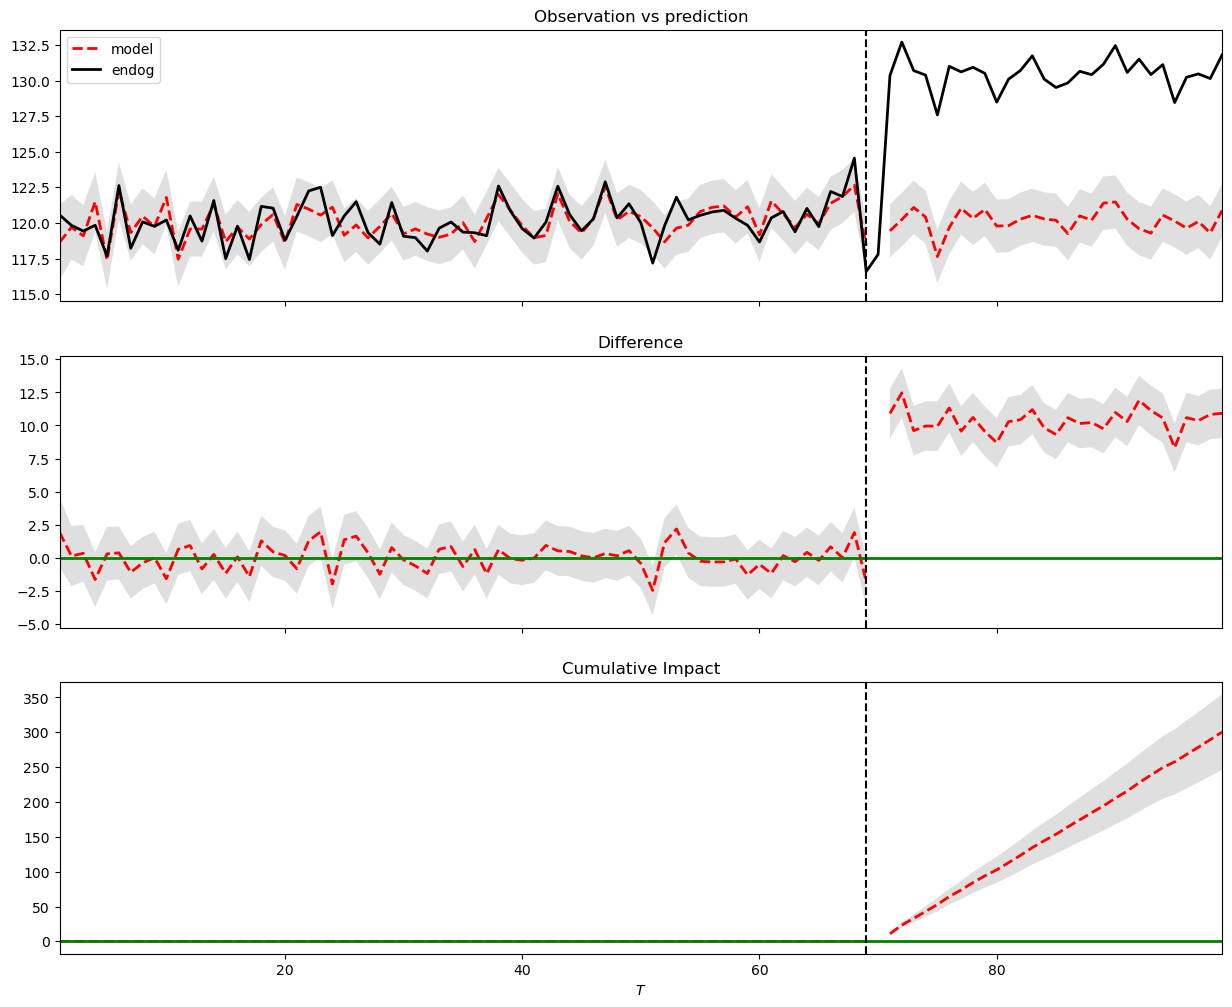

In [18]:
ts_impact.plot()

### Available options

* `ndraws` Number of MCMC samples to draw. More samples lead to more accurate inferences. Defaults to __1000__.

* `nburn` Number of burn in samples. This specifies how many of the initial samples will be discarded. defaults to 10% of ndraws.

* `standardize_data` Whether to standardize all columns of the data before fitting the model. This is equivalent to an empirical Bayes approach to setting the priors. It ensures that results are invariant to linear transformations of the data. Defaults to __TRUE__.

* `prior_level_sd` Prior standard deviation of the Gaussian random walk of the local level. Expressed in terms of data standard deviations. Defaults to __0.01__, a typical choice for  well-behaved and stable datasets with low residual volatility after regressing out known predictors (e.g., web searches or sales in high quantities). When in doubt, a safer option is to use __0.1__, as validated on synthetic data, although this may sometimes give rise to unrealistically wide prediction intervals.

* `nseasons` Period of the seasonal components. In order to include a seasonal component, set this to a whole number greater than 1. For example, if the data represent daily observations, use 7 for a day-of-week component. This interface currently only supports up to one seasonal component. To specify multiple seasonal components, use bsts to specify the model directly, then pass the fitted model in as bsts.model. Defaults to __1__, which means no seasonal component is used.

* `season_duration` Duration of each season, i.e., number of data points each season spans. Defaults to __1__. For example, to add a day-of-week component to data with daily granularity, use __model_args = list(nseasons = 7, season_duration = 1)__. To add a day-of-week component to data with hourly granularity, set __model_args = list(nseasons = 7, season_duration = 24)__.

* `dynamic_regression` Whether to include time-varying regression coefficients. In combination with a time-varying local trend or even a time-varying local level, this often leads to overspecification, in which case a static regression is safer. Defaults to __FALSE__.

## 8. Using a custom model

Instead of using the default model constructed by the CausalImpact package, we can use the UnobservedComponents model from the statsmodels package to specify our own model. This provides the greatest degree of flexibility.

Before constructing a custom model, we set the observed data in the post-treatment period to NA, reflecting the fact that the counterfactual response is unobserved after the intervention. We keep a copy of the actual observed response in the variable `post_period_response`.

In [19]:
post_period = [70,100]
post_period_response = y[post_period[0]:post_period[1]].copy()
y[post_period[0]:post_period[1]] = np.nan

We next set up and estimate a time series model using the statsmodels package. Here is a simple example:

In [20]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
ucm_model = UnobservedComponents(endog=y, level="llevel")
custom_impact = CausalImpact(ucm_model=ucm_model, post_period_response=post_period_response)
custom_impact.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29676D+00    |proj g|=  1.16557D-01

At iterate    5    f=  1.27429D+00    |proj g|=  2.71968D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      9      1     0     0   1.451D-07   1.274D+00
  F =   1.2742850362213849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


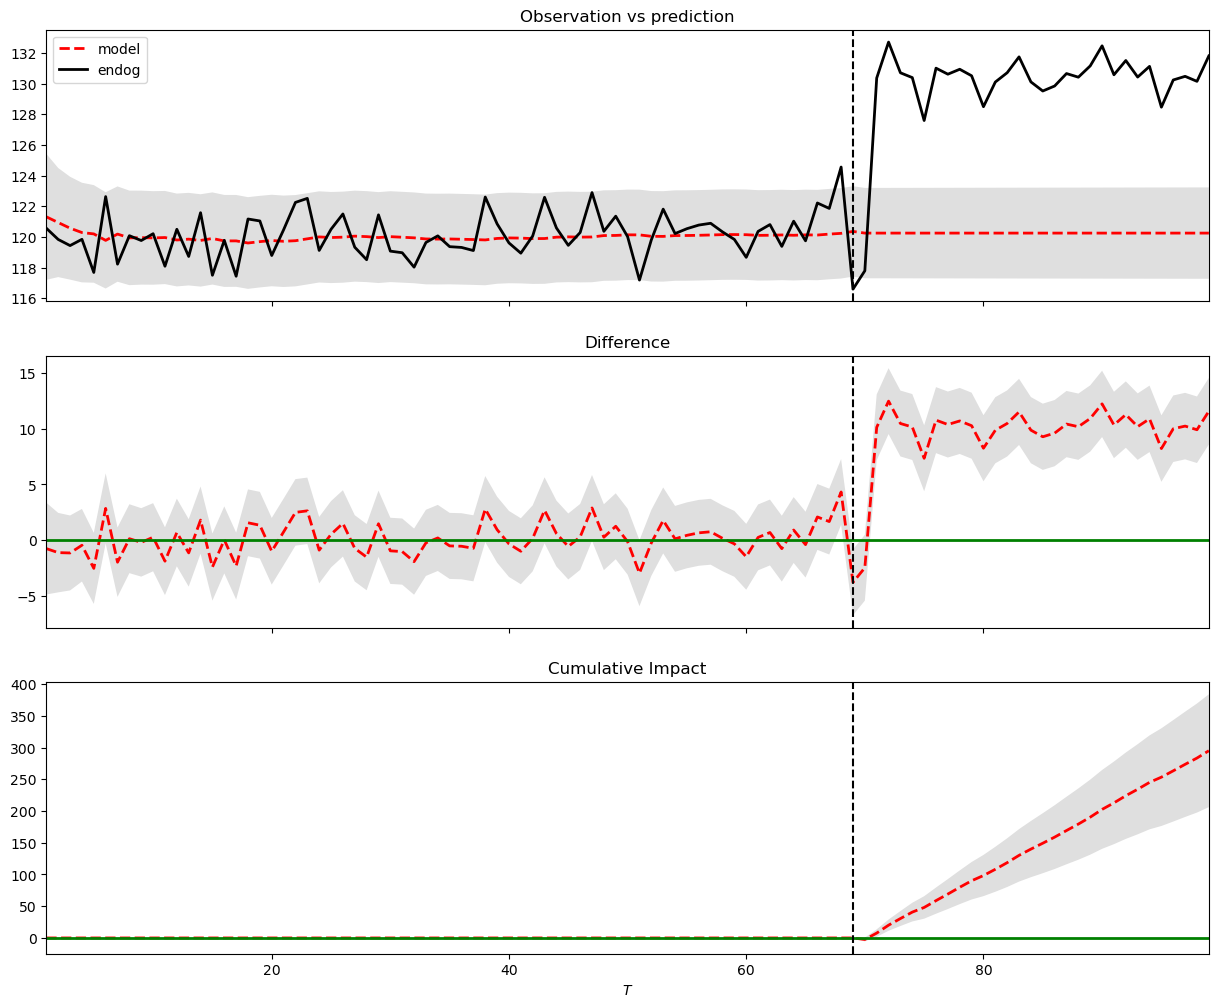

In [21]:
custom_impact.plot()

In [22]:
custom_impact.inferences.head()

,response,cum_response,point_pred,point_pred_lower,point_pred_upper,cum_pred,cum_pred_lower,cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cum_effect,cum_effect_lower,cum_effect_upper
0,121.308920,121.308920,0.000000,-1959.966134,1959.966134,0.000000,-1959.966134,1959.966134,121.308920,2081.275055,-1838.657214,0.0,0.0,0.0
1,120.563149,241.872070,121.308654,117.202395,125.414913,121.308654,-1842.763739,2085.381048,-0.745505,3.360754,-4.851764,0.0,0.0,0.0
2,119.832495,361.704565,120.935753,117.379151,124.492354,242.244407,-1725.384588,2209.873402,-1.103257,2.453344,-4.659859,0.0,0.0,0.0
3,119.433612,481.138177,120.567508,117.213863,123.921153,362.811915,-1608.170725,2333.794556,-1.133896,2.219749,-4.487541,0.0,0.0,0.0
4,119.840664,600.978841,120.283238,117.035651,123.530825,483.095153,-1491.135074,2457.325381,-0.442574,2.805013,-3.690161,0.0,0.0,0.0


Finally, we call `CausalImpact()`. Instead of providing input data, we simply pass in the fitted model object (`bsts_model`). We also need to provide the actual observed response. This is needed so that the package can compute the difference between predicted response (stored in `bsts_model`) and actual observed response (stored in `post_period_response`).

## 9. Using Bayesian Inference
Instead of using MLE we can use pymc for bayesian estimation. This uses the NUTS sampler. Currently the only two parameters that can be used to tune the model is the number of draws and the number of burn-in samples. The performance of this will be significantly slower than the default MLE approach.

In [23]:
bayes_impact = CausalImpact(data, pre_period, post_period, estimation="pymc", model_args={"ndraws":3000, "nburn":300})

In [24]:
bayes_impact.run()

/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sampling 4 chains for 300 tune and 3_000 draw iterations (1_200 + 12_000 draws total) took 18 seconds.
/opt/conda/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:789: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/conda/lib/python3

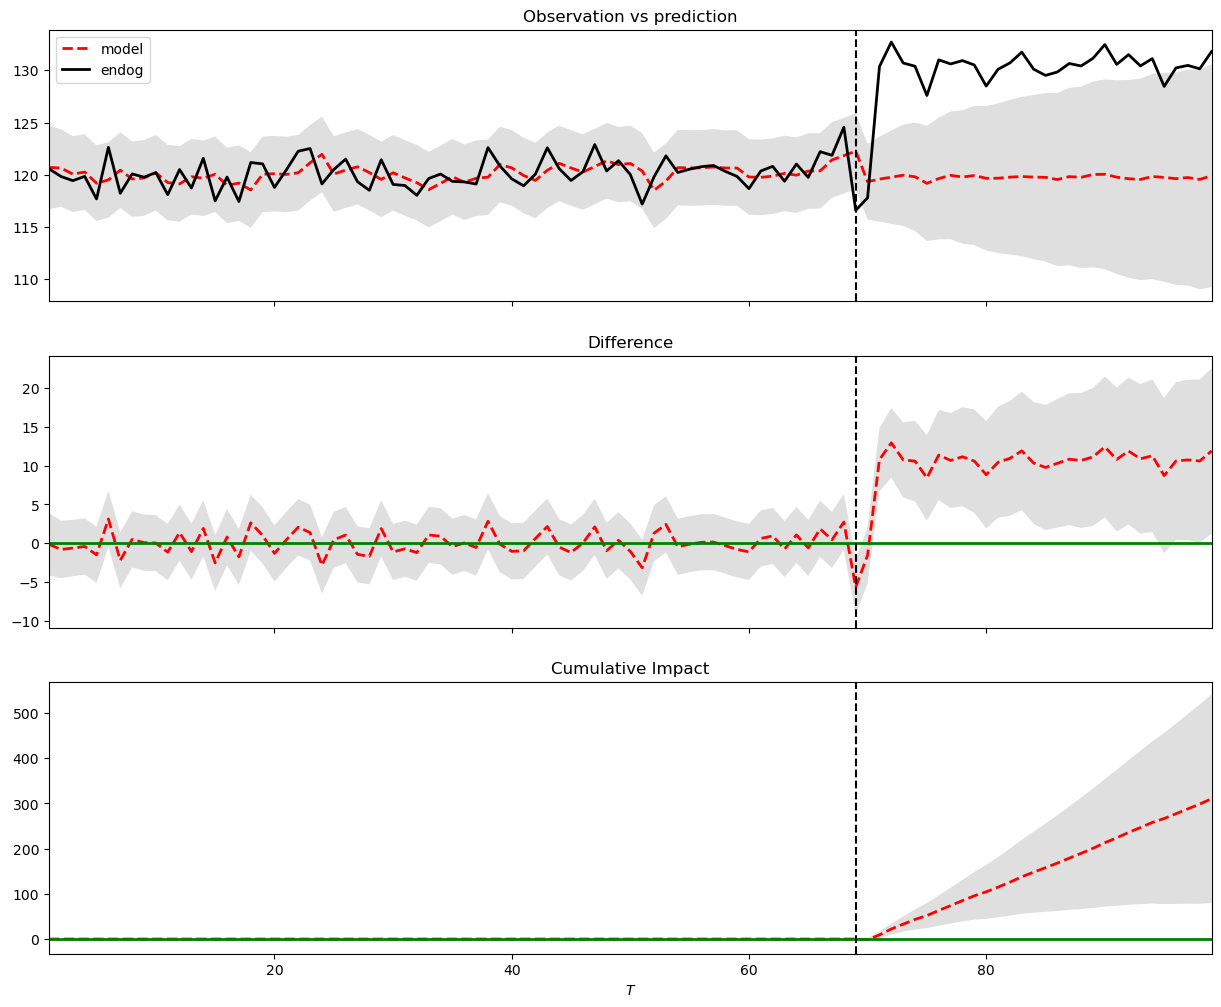

In [25]:
bayes_impact.plot()

## 9. FAQ

### How can I check whether the model assumptions are fulfilled?
It's the elephant in the room with any causal analysis on observational data: how can we verify the assumptions that go into the model? Here are a few ways of getting started. First of all, it is critical to reason why the covariates that are included in the model (this was *x1* in the example) *were not themselves affected* by the intervention. Sometimes it helps to plot all covariates and do a visual sanity check. Next, it is a good idea to examine how well the outcome data *y* can be predicted *before the beginning of the intervention*. This can be done by running `CausalImpact()` on an imaginary intervention. Then check how well the model predicted the data following this imaginary intervention. We would expect not to find a significant effect, i.e., counterfactual estimates and actual data should agree reasonably closely. Finally, when presenting or writing up results, be sure to list the above assumptions explicitly, including the priors in `model_args`, and discuss them with your audience.

### May the data contain missing values?
The response variable (i.e., the first column in data) may contain missing values (`NA`), but covariates (all other columns in data) may not. If one of your covariates contains missing values, consider imputing (i.e., estimating) the missing values; if this is not feasible, leave the regressor out.

### How can I customize the default plot?
By default, `impact.plot()` creates three panels, showing the counterfactual, pointwise, and cumulative impact estimates. One way of customizing the plot is to specify which panels should be included:

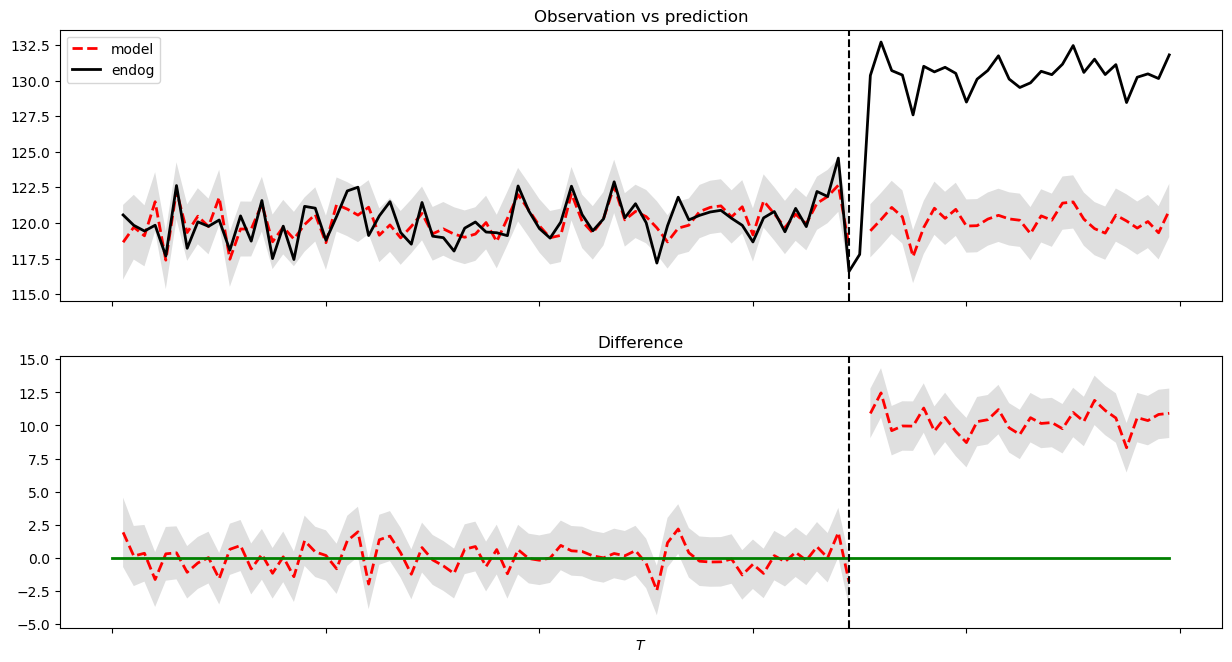

In [26]:
impact.plot(["original", "pointwise"])

This creates a plot without cumulative impact estimates. This is sensible whenever the response variable represents a stock quantity that cannot be meaningfully summed up across time (e.g., number of current subscribers), rather than a flow quantity (e.g., number of clicks).

### How can I change the font size in the plot?
The `plot()` function for `CausalImpact` objects returns a matplotlib object. This means we can customize the plot using standard bokeh functions. For example, to increase the font size, we can do:

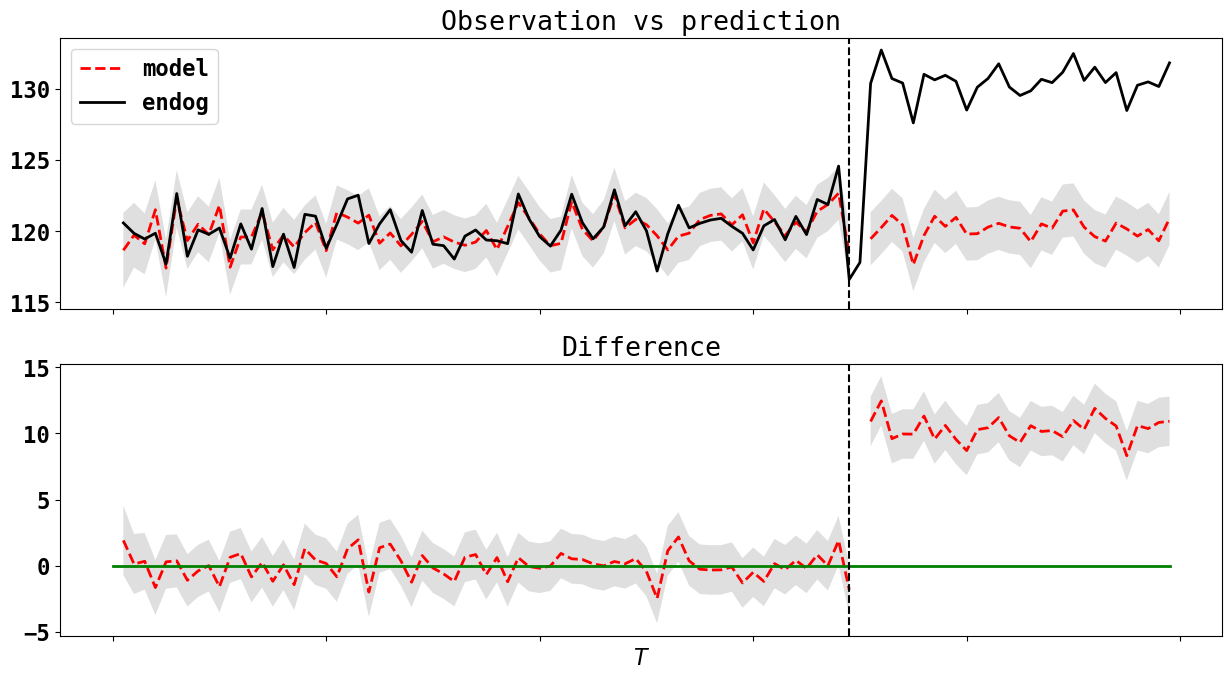

In [27]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
impact.plot(["original", "pointwise"])
# reset back to normal
font = {'family' : 'sans serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

### How can I obtain 90% intervals instead of 95% intervals?
The size of the intervals is specified by the argument `alpha`, which defaults to 0.05. To obtain 90% intervals instead, we would use:

In [28]:
perc_90_impact = CausalImpact(data, pre_period, post_period, alpha = 0.1)

### How can I validate my models performance
There is a set of diagnostic plots that will allow you to view the residuals and validate their normality

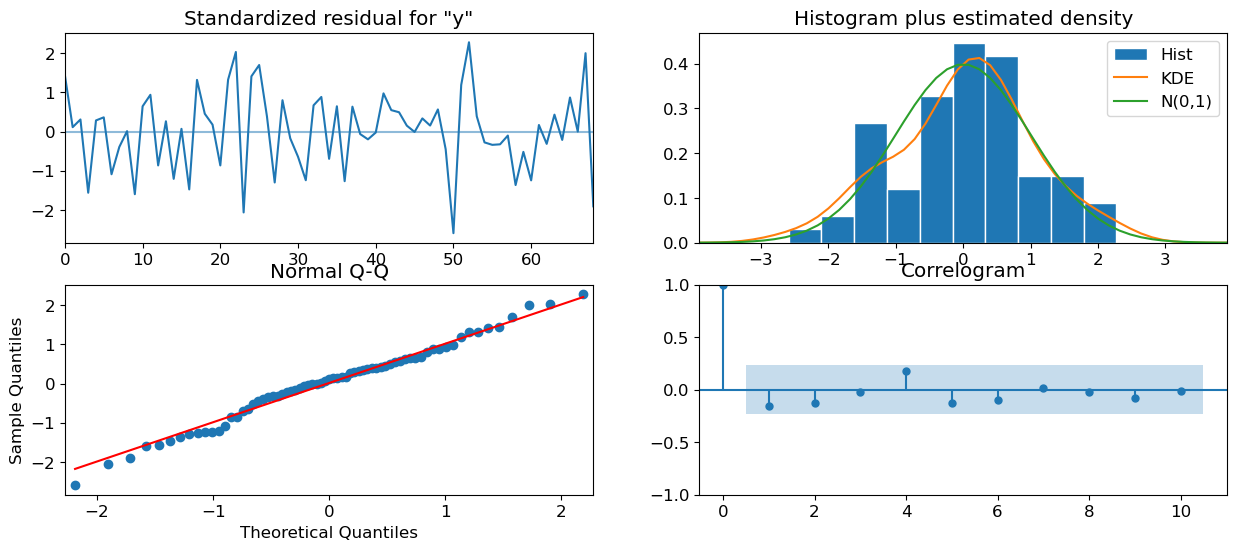

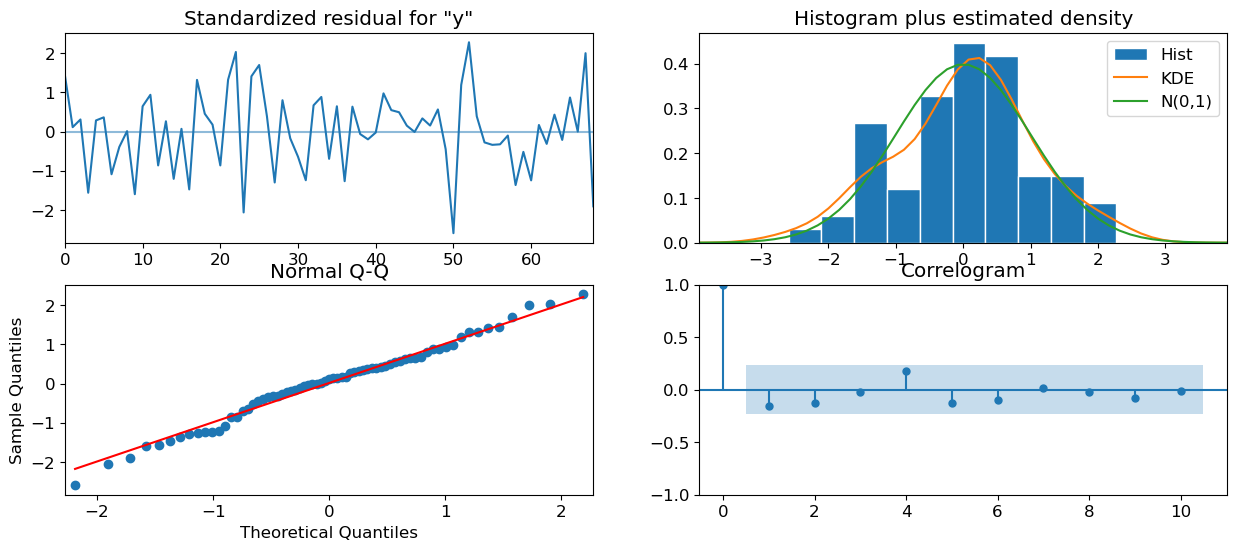

In [29]:
impact.results.results.plot_diagnostics()

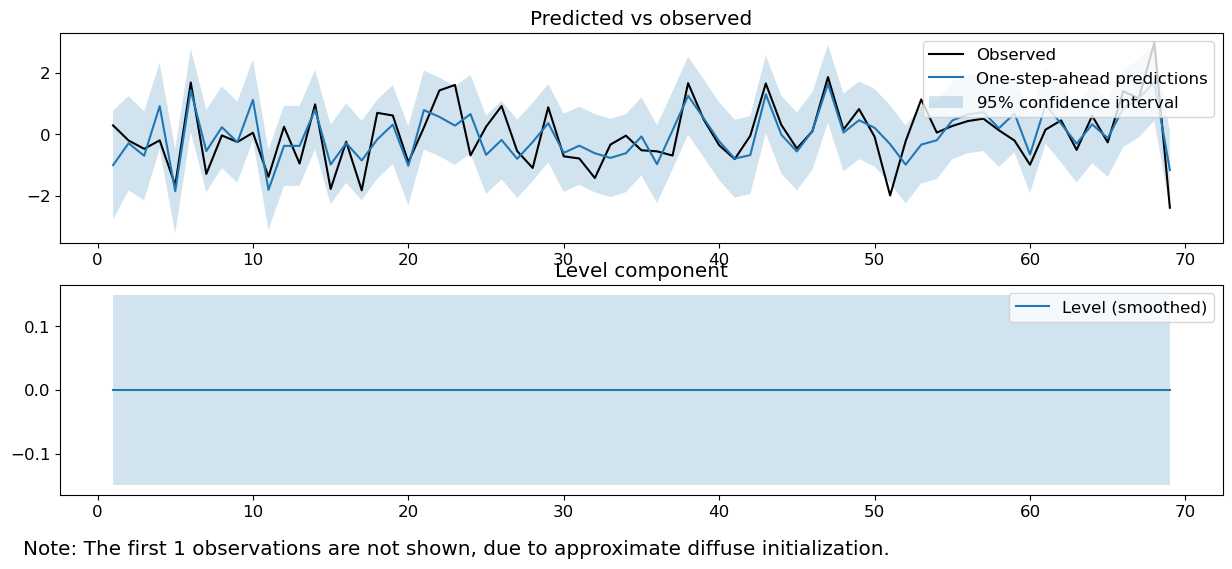

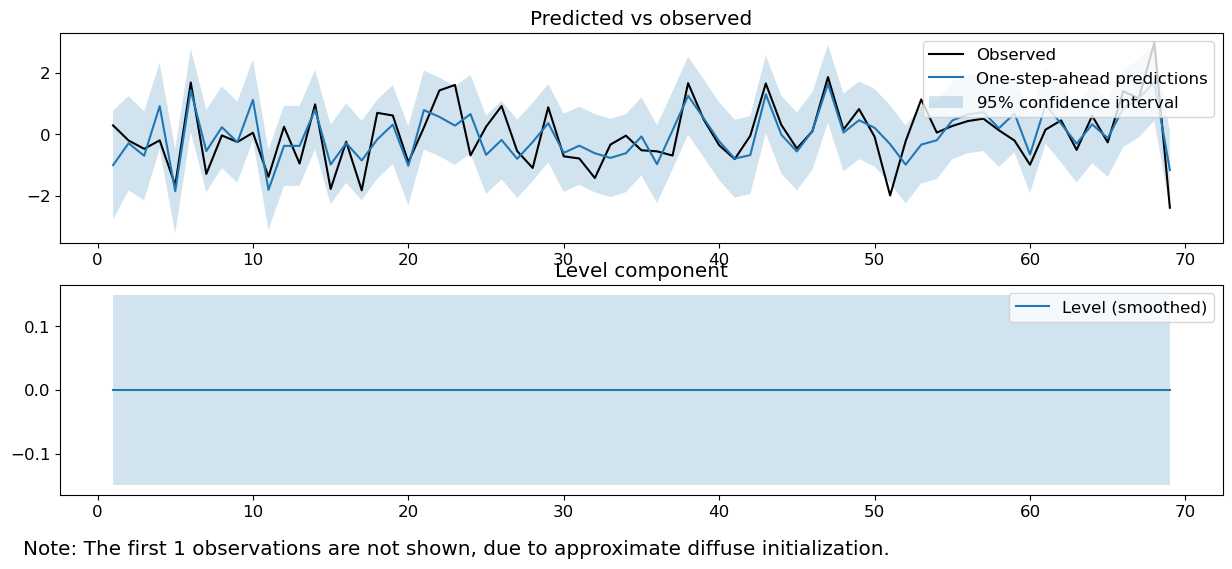

In [30]:
impact.results.results.plot_components()

### Which predictor variables were used in the model?
Analyses may easily contain tens or hundreds of potential predictors (i.e., columns in the data function argument). Which of these were informative? We can plot the posterior probability of each predictor being included in the model using:

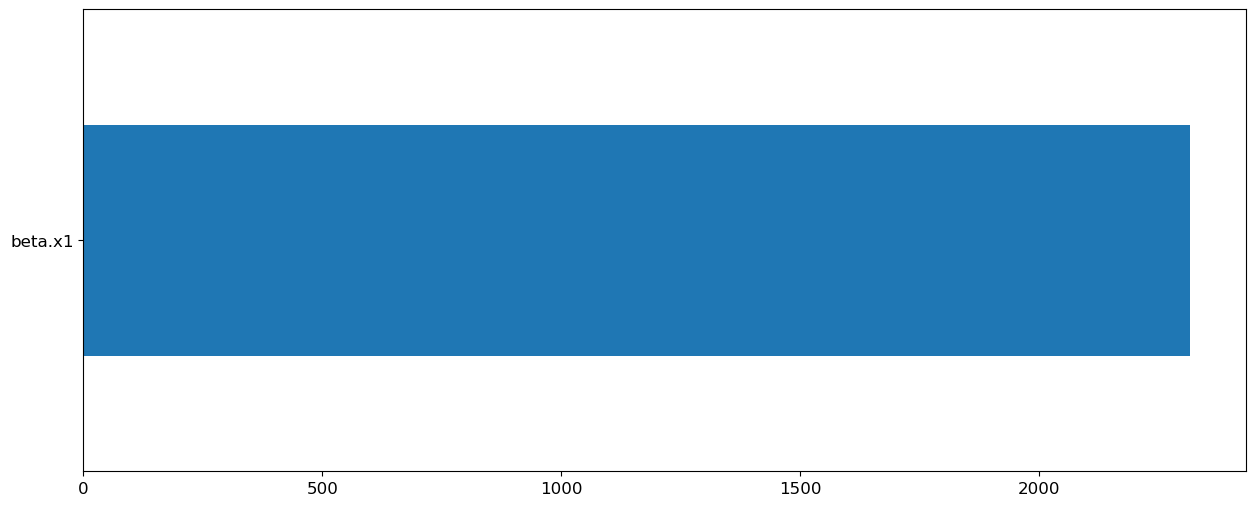

In [31]:
# TODO: something like this
params = pd.DataFrame(impact.results.results.params).T
params.columns = impact.results.results.param_names 
betas = [column for column in params.columns if column.startswith("beta")]
beta_params = params.loc[:, betas]
# exogenous data for the post period
exog_post = data.iloc[post_period[0]:, 1:]

contribution = np.dot(exog_post, beta_params)
contribution = pd.DataFrame(contribution, columns=betas).sum(axis=0)
contribution.plot(kind="barh");